# Chapter 4
`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`

______

## The greatest theorem never told
本章重点介绍一个总是在我们脑海里反复出现的想法，但很少在专门用于统计学的书籍之外显示出来。实际上，到目前为止，我们一直在使用这个简单的想法。

### The Law of Large Numbers
让$Z_i$是从某个概率分布采样的$N$个独立样本。根据*大数定理*，只要期望值$E[Z]$有限，以下成立:

$$\frac{1}{N}\sum_{i=1}^{N}Z_i \rightarrow E[ Z ], \;\;\; N \rightarrow \infty$$

翻译过来就是：
>来自相同分布的随机变量序列的平均值收敛到该分布的期望值。

这似乎是一个无聊的结果，但它将是你使用最有用的工具。

### Intuition
如果上述法则有些令人惊讶，可以通过检查一个简单的例子来更清楚。 

考虑一个随机变量$Z$，它只能取两个值，即$c_1$和$c_2$。假设我们有大量的$Z$样本，表示一个特定的样本$Z_i$。法则规定，我们可以通过所有样本的平均值近似$Z$的期望值。考虑平均值：

$$ \frac{1}{N} \sum_{i=1}^N \;Z_i $$

通过构建，$Z_i$只能取$c_1$或$c_2$，因此我们可以对这两个值进行分割，分别求和：

\begin{align}
\frac{1}{N} \sum_{i=1}^N \;Z_i
& =\frac{1}{N} \big(  \sum_{ Z_i = c_1}c_1 + \sum_{Z_i=c_2}c_2 \big) \\\\[5pt]
& = c_1 \sum_{ Z_i = c_1}\frac{1}{N} + c_2 \sum_{ Z_i = c_2}\frac{1}{N} \\\\[5pt]
& = c_1 \times \text{ (approximate frequency of $c_1$) } \\\\ 
& \;\;\;\;\;\;\;\;\; + c_2 \times \text{ (approximate frequency of $c_2$) } \\\\[5pt]
& \approx c_1 \times P(Z = c_1) + c_2 \times P(Z = c_2 ) \\\\[5pt]
& = E[Z]
\end{align}

在极限之中同样成立，但通过使用越来越多的样本，我们可以越来越近。这项法则适用于几乎*任何分布*，除了稍后会遇到的一些重要案例。

##### Example
-------
以下是三个不同序列的泊松随机变量的大数法则图。 

我们采样`sample_size = 100000`个泊松随机变量，参数$\lambda=4.5$。（回想一下泊松随机变量的期望值等于它的参数。）我们计算前$n$个样本的平均值，即$n = 1$到`sample_size`。

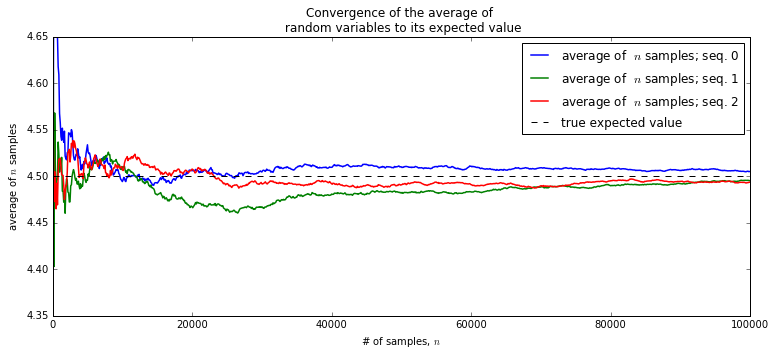

In [6]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize( 12.5, 5 )

sample_size = 100000
expected_value = lambda_ = 4.5
poi = np.random.poisson
N_samples = range(1,sample_size,100)

for k in range(3):

    samples = poi( lambda_, sample_size ) 
    
    partial_average = [ samples[:i].mean() for i in N_samples ]
    
    plt.plot( N_samples, partial_average, lw=1.5,label="average \
of  $n$ samples; seq. %d"%k)
    

plt.plot( N_samples, expected_value*np.ones_like( partial_average), 
    ls = "--", label = "true expected value", c = "k" )

plt.ylim( 4.35, 4.65) 
plt.title( "Convergence of the average of \n random variables to its \
expected value" )
plt.ylabel( "average of $n$ samples" )
plt.xlabel( "# of samples, $n$")
plt.legend();

看上面的图，很清楚，当样本量很小时，平均值的变化会更大（比较平均值最初是如何锯齿状和跳跃，然后变得平滑）。所有三个路径*接近*值4.5，只是因为$N$变大导致的。数学家和统计学家有另一个*调情*的名字：收敛。 

我们可以问的另一个非常相关的问题是什么时候*快速收敛*到*期望值*？让我们画一些新的东西。对于特定的$N$，让我们进行数千次的上述测试，看看计算的平均值距离真实期望值有多远。等等，计算平均值？这又是大数的法则了！例如，对于特定的$N$，我们感兴趣的是数量：

$$D(N) = \sqrt{ \;E\left[\;\; \left( \frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \;\right)^2 \;\;\right] \;\;}$$

对于某些$N$，上述公式可解释为远离真实值（在平均值上）的距离。（我们取平方根，所以上述量的维度和我们的随机变量是相同的）。由于上述是期望值，可以使用大数法来近似：$不是平均Z_i$，我们计算以下多次并平均：

$$ Y_k = \left( \;\frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \; \right)^2 $$

通过计算上述公式多次，$N_y$次（记住，它是随机的），并且将其求平均：

$$ \frac{1}{N_Y} \sum_{k=1}^{N_Y} Y_k \rightarrow E[ Y_k ] = E\;\left[\;\; \left( \frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \;\right)^2 \right]$$

最后，得到其平方根：

$$ \sqrt{\frac{1}{N_Y} \sum_{k=1}^{N_Y} Y_k} \approx D(N) $$ 

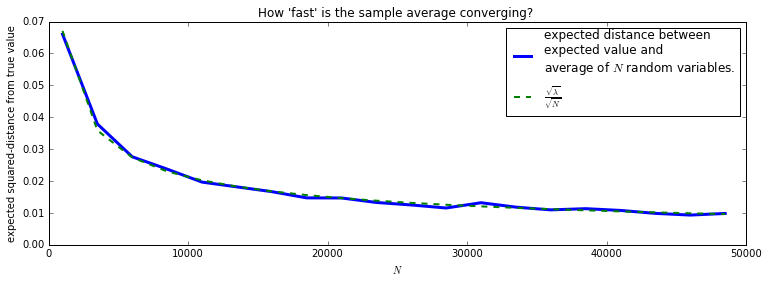

In [3]:
figsize( 12.5, 4)

N_Y = 250 #use this many to approximate D(N)
N_array = np.arange( 1000, 50000, 2500 ) #use this many samples in the approx. to the variance.
D_N_results = np.zeros( len( N_array ) )

lambda_ = 4.5 
expected_value = lambda_ #for X ~ Poi(lambda) , E[ X ] = lambda

def D_N( n ):
    """
    This function approx. D_n, the average variance of using n samples.
    """
    Z = poi( lambda_, (n, N_Y) )
    average_Z = Z.mean(axis=0)
    return np.sqrt( (  (average_Z - expected_value)**2  ).mean() )
    
    
for i,n in enumerate(N_array):
    D_N_results[i] =  D_N(n)


plt.xlabel( "$N$" )
plt.ylabel( "expected squared-distance from true value" )
plt.plot(N_array, D_N_results, lw = 3, 
            label="expected distance between\n\
expected value and \naverage of $N$ random variables.")
plt.plot( N_array, np.sqrt(expected_value)/np.sqrt(N_array), lw = 2, ls = "--", 
        label = r"$\frac{\sqrt{\lambda}}{\sqrt{N}}$" )
plt.legend()
plt.title( "How 'fast' is the sample average converging? " );

正如预期的那样，随着$N$的增长，我们的样本平均值与实际期望值之间的预期距离将缩小。但也注意到收敛速度下降，也就是说，我们只需要10000个样本，就能从0.020移动到0.015，差异为0.005，但是20000个样本才能再次从0.015下降到0.010，再次下降了0.005个。

这证明了我们可以衡量这个收敛速度。上面我画的第二条线，函数为$\sqrt{\lambda}/\sqrt{N}$。这不是任意选择的。在大多数情况下，给定一个如随机变量序列的分布如$Z$，大数法则的收敛到$E[Z]$的速度为

$$ \frac{ \sqrt{ \; Var(Z) \; } }{\sqrt{N} }$$

这有助于知道：对于给定的大的$N$，我们知道（在平均上）我们距离估计有多远。另一方面，在贝叶斯环境中，这似乎是一个无用的结果：贝叶斯分析在不确定的前提下也是可用的，所以添加额外精度的*统计点*是什么？虽然用样本绘图可以如此计算便宜，具有较大的$N$也是很好的。

### How do we compute $Var(Z)$ though?
方差只是可以近似的另一个预期值！考虑以下，一旦我们有预期值（通过使用大数法来估计它，表示为$\mu$），我们可以估计它的方差：

$$ \frac{1}{N}\sum_{i=1}^N \;(Z_i - \mu)^2 \rightarrow E[ \;( Z - \mu)^2 \;] = Var( Z )$$

### Expected values and probabilities 
期望值与估计的概率之间的关系更不明显。定义*指示函数*

$$\mathbb{1}_A(x) = 
\begin{cases} 1 &  x \in A \\\\
              0 &  else
\end{cases}
$$

那么，按照大数定理，如果我们有很多样本$X_i$，我们可以通过以下方式估计事件A的概率，表示为$P(A)$：

$$ \frac{1}{N} \sum_{i=1}^N \mathbb{1}_A(X_i) \rightarrow E[\mathbb{1}_A(X)] =  P(A) $$

再次，在想一会之后，可以发现这是很明显想法：指标函数只有在事件发生时为1，所以我们只求和事件发生的次数除以总试验次数（考虑我们通常如何使用频率来近似表示概率）。例如，假设我们希望估计$Z \sim Exp(.5)$大于5的概率，并且我们有一个来自$Exp(.5)$分布的许多样本。

$$ P( Z > 5 ) =  \frac{1}{N}\sum_{i=1}^N \mathbb{1}_{z > 5 }(Z_i) $$

In [5]:
N = 10000
print( np.mean( [ np.random.exponential( 0.5 ) > 5 for i in range(N) ] ) )

0.0001


### What does this all have to do with Bayesian statistics? 
在下一章中介绍的*点估计*，贝叶斯推理是使用期望值来计算的。在更多的分析贝叶斯推理中，我们要做的是计算表示为多维积分的复杂期望值。如果我们可以直接从后验分布中抽样，我们只需要计算其平均值。更容易如果准确度是一个先验分布，像上面的图表显示你收敛的速度。如果需要进一步的准确度，只需从后验分布中获取更多的样本。

什么时候够了？什么时候可以停止从后验分布中抽样？那就是人决定的，也取决于样本的方差（回忆上面的例子中高方差意味着平均值会收敛的较慢）。

我们也应该明白什么时候大数法则失效。顾名思义，并且比较上述的图中少量的$N$，该法仅适用于大样本量。没有这个，渐近的结果是不可靠的。所以说，*在不确信应该如何继续做时*，可以知道在什么情况下，法则无法让我们*有信心*。下一节讨论这个问题。

## The Disorder of Small Numbers
大数法则只有$N$*无限大*才有效：从来没有真正实现。虽然大数法则是一个强大的工具，但是使用的条件却很宽松。我们的下一个例子说明了这一点。

##### Example: Aggregated geographic data
通常，数据以聚合形式出现。例如，数据可以按州，县或市级分组。当然，人口数量因地理区域而异。如果数据是每个地理区域的一些特征的平均值，我们必须意识到“大数法”，以及它如何在人口少的地区*失效*。

我们将在玩具数据集上观察。假设我们的数据集中有五千个县。此外，每个州的人口数量均匀分布在100到1500之间。人口数量的产生方式与讨论无关，所以我们不讨论这个。我们有兴趣衡量每个县的个人平均身高。我们不知道，身高与其所处的县是*不相关的*，每个人，无论他或她目前住在哪里，他们身高都来自于相同的分布：

$$ \text{height} \sim \text{Normal}(150, 15 ) $$

我们以县为单位聚合数据，所以我们只有县内的*平均*数据。我们的数据集可能是什么样的？

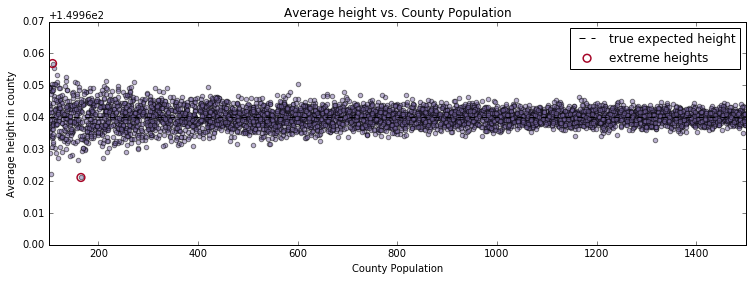

In [6]:
figsize( 12.5, 4) 
std_height = 15
mean_height = 150

n_counties = 5000
pop_generator = np.random.randint
norm = np.random.normal

#generate some artificial population numbers
population = pop_generator(100, 1500, n_counties )

average_across_county = np.zeros( n_counties )
for i in range( n_counties ):
    #generate some individuals and take the mean
    average_across_county[i] = norm(mean_height, 1./std_height,
                                        population[i] ).mean()
    
#located the counties with the apparently most extreme average heights.
i_min = np.argmin( average_across_county )
i_max = np.argmax( average_across_county )

#plot population size vs. recorded average
plt.scatter( population, average_across_county, alpha = 0.5, c="#7A68A6")
plt.scatter( [ population[i_min], population[i_max] ], 
           [average_across_county[i_min], average_across_county[i_max] ],
           s = 60, marker = "o", facecolors = "none",
           edgecolors = "#A60628", linewidths = 1.5, 
            label="extreme heights")

plt.xlim( 100, 1500 )
plt.title( "Average height vs. County Population")
plt.xlabel("County Population")
plt.ylabel("Average height in county")
plt.plot( [100, 1500], [150, 150], color = "k", label = "true expected \
height", ls="--" )
plt.legend(scatterpoints = 1);

我们观察到什么？在*不考虑人口规模*的前提下，我们冒着巨大的推理错误的风险：如果我们忽略了人口规模，我们会说，最矮和最高的个人所处的县被正确地圈出来了。但这个推论是错误的，原因如下。这两个县*不*需要有最极端的高度。误差来自较小群体的计算平均值，不能很好地反映出群体的真实期望值（实际上应该是$\mu=150$）。样本大小/人口大小$N$，无论想要什么，都是太小，无法有效地使用$大数法则$。

我们提供更多有悖于此推论的证据。回想人口数量在100到1500之间是均匀分布的。我们的直觉应该告诉我们，存在身高最极端的县也应该均匀分布在100到4000之间，当然与县的人口无关。不是这样的，以下是最极端身高的县的人口规模。

In [7]:
print("Population sizes of 10 'shortest' counties: ")
print(population[ np.argsort( average_across_county )[:10] ], '\n')
print("Population sizes of 10 'tallest' counties: ")
print(population[ np.argsort( -average_across_county )[:10] ])

Population sizes of 10 'shortest' counties: 
[165 104 159 118 209 144 147 103 115 217] 

Population sizes of 10 'tallest' counties: 
[108 110 116 134 215 134 272 153 116 158]


在100到1500之间不是均匀分布的。这是大数法的绝对失败。

##### Example:  Kaggle's *U.S. Census Return Rate Challenge*
以下是2010年美国人口普查的数据，其将属于某县的人口划分到区块组（城市街区或等同物的聚合）水平。数据集来自Kaggle机器学习比赛，我和一些同事参加了了，比赛的题目是预测一个组块的普查信件回邮率，用0到100之间的数字，使用普查变量（中位数收入，组块中的女性人数，拖车公园数，平均儿童人数等）。下面我们绘制人口普查回邮率与块组人口的关系图：

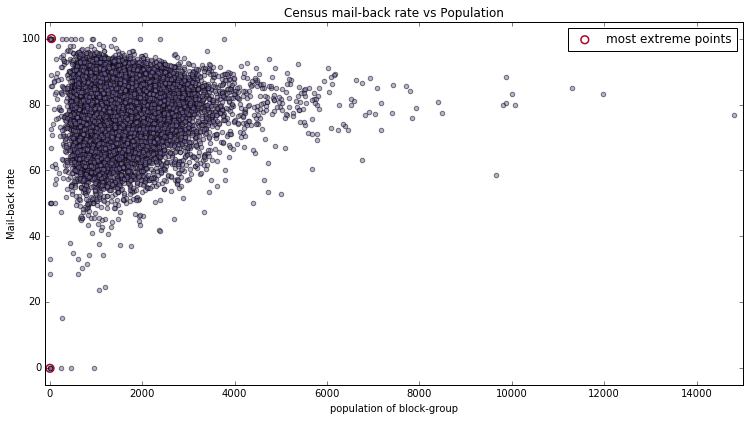

In [7]:
figsize( 12.5, 6.5 )
data = np.genfromtxt( "./data/census_data.csv", skip_header=1, 
                        delimiter= ",")
plt.scatter( data[:,1], data[:,0], alpha = 0.5, c="#7A68A6")
plt.title("Census mail-back rate vs Population")
plt.ylabel("Mail-back rate")
plt.xlabel("population of block-group")
plt.xlim(-100, 15e3 )
plt.ylim( -5, 105)

i_min = np.argmin(  data[:,0] )
i_max = np.argmax(  data[:,0] )
 
plt.scatter( [ data[i_min,1], data[i_max, 1] ], 
             [ data[i_min,0],  data[i_max,0] ],
             s = 60, marker = "o", facecolors = "none",
             edgecolors = "#A60628", linewidths = 1.5, 
             label="most extreme points")

plt.legend(scatterpoints = 1);

以上是统计学中的一个典型现象。我说*经典*指的是上面散点图的“形状”。它遵循经典的三角形形式，随着我们增加样本大小（如大数法则变得更精确），它们会收紧。 

我可能过分强调了这一点，也许我应该把这本书命名为“你没有大数据问题！”，但这里又是一个*小数据集*带来麻烦的例子，而不是大数据集。简单来说，小数据集不能使用大数法则进行处理。与大数据集（例如大数据）相比，适用大数法则却没有麻烦。我之前提到，相对简单的算法解决了矛盾的大数据预测问题。通过了解大数法则创造出*稳定*的解决方案，即增加或减少几个数据点将不会对解决方案产生很大影响，部分解决了这个矛盾。另一方面，在小数据集中，添加或删除数据点可以产生非常不同的结果。

为了进一步阅读“大数法”的隐患，我强烈推荐[“最危险的方程式”](http://nsm.uh.edu/~dgraur/niv/TheMostDangerousEquation.pdf)。

##### Example: How to order Reddit submissions
你可能不同意原来的说法:大数法则是所有人都知道的，只是隐含在我们的潜意识决策中。考虑在线产品的评级：如果只有1位评论者，你会多相信平均5星评级？ 2个评论者呢？ 3个评论者呢？我们隐含地理解，这么少的评论者，平均评级不能很好地反映产品的真实价值。 

这造成了我们如何对产品进行排序的缺陷，更普遍地说，我们如何比较产品好坏。许多人意识到，通过评分排序在线搜索结果，无论对象是书籍，视频还是在线评论，都会返回不佳的结果。通常，似乎顶级的视频只从一些热心的粉丝才能获得完美的评分，并且真正更高质量的视频因为虚假的不合标准的评级4.8附近而被放在了后面的页面。我们该如何纠正这个问题？

考虑流行的网站Reddit（我有意没有链接到网站，因为你永远不会回来）。该网站托管了故事或图像的链接，称为提交submission，供人们评论。用户可以对每个提交投票支持（称为upvotes和downvotes）。 Reddit默认情况下，将通过Hot将提交的内容排序到给定的subreddit，也就是最近获得最多投票的提交。

<img src="http://i.imgur.com/3v6bz9f.png" />

你如何确定哪些提交是最好的？有很多方法可以实现这一点：
1. 人气：如果它有很多upvote，一个提交被认为是好的。这个模式的一个问题是，提交有数百个upvote，但也有成千上万的downvote。虽然非常*受欢迎*，但提交看上去争议更多。 
2. 区别：使用upvote和downvote的*区别difference*。这解决了上述问题，但是当我们考虑到提交的时间性质时，就会失败。根据发布提交的时间，网站可能会遇到高流量或低流量。差异方法会将Top提交的内容偏向于在高流量期间提交的内容，这些提交会相比高峰期没有提交的积累更多投票，但不一定是最好的。 
3. 时间调整：考虑使用差异除以提交的年龄。这创造了一个*rate*，像每分钟或每秒钟的*差异*。一个立即的反例是，如果我们使用每秒作为周期，每秒收到一个投票的旧提交，将比一个100秒收到99个投票的的旧提交更好。可以通过只考虑至少$t$秒内的一个旧提交，避免这种情况。但是什么是好的$t$值？这是否意味着比周期$t$短的提交都不好？我们最终比较的是不稳定的数量与稳定的数量（新的和旧的提交）。 
4. 比率：按赞成票与总票数比例（upvotes plus downvotes）排名提交。这解决了时间问题，因为只要他们有很多总赞成票，得分好的新提交可以被认为是顶级，就像老年提交一样可能。这里的问题是，若某个提交只有一个upvote（比例= 1.0），那么它将以999次upvote和1次downvote（比例= 0.999）的递交打败，但显然后者的提交*更有可能*更好。

我用*更有可能*是有理由的。以前的提交只有一个upvote，但事实上比之后有999个upvote的提交更好是可能的。犹豫同意这一点是因为我们还没有看到前一次提交的999个潜在投票。也许它会实现额外的999次upvote和0次downvote，并被认为比后者更好，尽管不太可能。 

我们真正想要的是真正的upvote比率的估计。请注意，真实的upvote比率与观察到的upvote比率是不一样的：真正的upvote比率是隐藏的，我们只是观察到已有的upvote与downvote（可以认为真正的upvote比例为“有人给这个提交upvote对比给downvote的潜在的概率”）。所以借助于大数法则，我们可以断言：999 upvote/1 downvote提交可能有一个真正的upvote比率接近1，但另一方面，在只有一个upvote的前提下，我们不太确定提交的真实upvote比率，这对我来讲听起来像贝叶斯问题。

确定upvote的先验分布的一种方法是查看upvote比率的历史分布。这可以通过爬取Reddit的提交来确定一个分布。虽然对于这技术有一些问题：
1. 倾斜的数据skewed data：绝大多数提交的投票票数极少，因此将有许多提交的比例接近极端值（参见上述Kaggle数据集中的“三角图”），这样会将我们的分布扭转到极端。人们可以尝试仅使用投票大于某个阈值的投票，可是再次遇到了问题。在可用的提交数量和具有相关比率精度的较高阈值之间存在折衷。 
2. 偏倚数据biased data：Reddit由不同的子页面组成，称为subreddits。两个例子是$r/aww$，它们发布可爱动物的照片和$r/politics$。用户对这两个子页面的提交的行为很有可能是非常不同的：访客在前者中可能很友好和深情，因此与后者相比，可以给出更多的upvote，而后者可能会引起争议，并且不同意其观点。所以不是所有的提交都是一样的。

鉴于这些，我认为使用`Uniform`作为先验分布。 

随着我们的先验分布确定下来，我们可以找到真正的upvote比率的后验分布。Python脚本`top_showerthoughts_submissions.py`将从Reddit上的`showerthoughts`社区中爬下最好的帖子。这是一个纯文本社区，所以每个帖子的标题就是帖子。以下是顶级帖子以及其他一些示例帖子：

In [8]:
#adding a number to the end of the %run call with get the ith top post.
%run top_showerthoughts_submissions.py 2

print("Post contents: \n")
print(top_post)

NoSectionError: No section: 'BayesianMethodsForHackers'
You provided the name of a praw.ini configuration which does not exist.

For help with creating a Reddit instance, visit
https://praw.readthedocs.io/en/latest/code_overview/reddit_instance.html

For help on configuring PRAW, visit
https://praw.readthedocs.io/en/latest/getting_started/configuration.html

Post contents: 



NameError: name 'top_post' is not defined

In [ ]:
"""
contents: an array of the text from the last 100 top submissions to a subreddit
votes: a 2d numpy array of upvotes, downvotes for each submission.
"""
n_submissions = len(votes)
submissions = np.random.randint( n_submissions, size=4)
print("Some Submissions (out of %d total) \n-----------"%n_submissions)
for i in submissions:
    print('"' + contents[i] + '"')
    print("upvotes/downvotes: ",votes[i,:], "\n")

对于给定的真实upvote比$p$和投票数$N$，upvote的数量将看起来像参数$p$和$N$的二项式随机变量。（这是因为在upvote率和upvoting对downvoting的概率之间的等价）。我们创建一个函数，对于某个提交的upvote/downvote pair，对$p$进行贝叶斯推理。

In [9]:
import pymc3 as pm

def posterior_upvote_ratio( upvotes, downvotes, samples = 20000):
    """
    This function accepts the number of upvotes and downvotes a particular submission recieved, 
    and the number of posterior samples to return to the user. Assumes a uniform prior.
    """
    N = upvotes + downvotes
    with pm.Model() as model:
        upvote_ratio = pm.Uniform("upvote_ratio", 0, 1)
        observations = pm.Binomial( "obs",  N, upvote_ratio, observed=upvotes)
        
        trace = pm.sample(samples, step=pm.Metropolis())
    
    burned_trace = trace[int(samples/4):]
    return burned_trace["upvote_ratio"]

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


下面是后验分布的结果展示。

In [10]:
figsize( 11., 8)
posteriors = []
colours = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#CF4457"]
for i in range(len(submissions)):
    j = submissions[i]
    posteriors.append( posterior_upvote_ratio( votes[j, 0], votes[j,1] ) )
    plt.hist( posteriors[i], bins = 10, normed = True, alpha = .9, 
            histtype="step",color = colours[i%5], lw = 3,
            label = '(%d up:%d down)\n%s...'%(votes[j, 0], votes[j,1], contents[j][:50]) )
    plt.hist( posteriors[i], bins = 10, normed = True, alpha = .2, 
            histtype="stepfilled",color = colours[i], lw = 3, )
    
plt.legend(loc="upper left")
plt.xlim( 0, 1)
plt.title("Posterior distributions of upvote ratios on different submissions");

NameError: name 'submissions' is not defined

一些分布非常紧，其他的分布非常长，相对而言，表达了我们的不确定性。

### Sorting!
我们一直在忽视这个练习的目标：我们如何将提交从最好到最坏排序？当然，我们不能排序分布，我们必须排序标量数。有很多方法可以将分布提炼到标量：通过其期望值或平均值来表达分布是一种方式。选择平均值是一个不错的选择。这是因为平均值没有考虑分布的不确定性。 

我建议使用95％的*最小合理值*，定义为：真实参数只有5％的几率更低（考虑95％可信区域的下限）。以下是后验分布，其最小合理值为95％：

In [11]:
N = posteriors[0].shape[0]
lower_limits = []

for i in range(len(submissions)):
    j = submissions[i]
    plt.hist( posteriors[i], bins = 20, normed = True, alpha = .9, 
            histtype="step",color = colours[i], lw = 3,
            label = '(%d up:%d down)\n%s...'%(votes[j, 0], votes[j,1], contents[j][:50]) )
    plt.hist( posteriors[i], bins = 20, normed = True, alpha = .2, 
            histtype="stepfilled",color = colours[i], lw = 3, )
    v = np.sort( posteriors[i] )[ int(0.05*N) ]
    #plt.vlines( v, 0, 15 , color = "k", alpha = 1, linewidths=3 )
    plt.vlines( v, 0, 10 , color = colours[i], linestyles = "--",  linewidths=3  )
    lower_limits.append(v)
    plt.legend(loc="upper left")

plt.legend(loc="upper left")
plt.title("Posterior distributions of upvote ratios on different submissions");
order = np.argsort( -np.array( lower_limits ) )
print(order, lower_limits)

IndexError: list index out of range

根据我们的程序，最好的提交是*最有可能*获得高百分比upvotes的提交。视觉上这些提交的95％最小合理值接近1。 

为什么根据这个量排序是个好主意？通过按95％的最低合理值排序，我们是最保守的，我们认为最好的。也就是说，即使在最糟糕的情况下，当我们严重高估upvote比率时，我们可以确定最好的提交仍然是在最前面的。在这个顺序下，我们强加了以下非常自然的属性：

1. 给出两个同样upvotes率的提交，我们将有更多的upvotes的提交认为更好（因为我们更有信心有它更高的upvotes比率）。 
2. 给出两个有同样数量的votes的提交，我们仍然会将存在更多upvotes的提交认为更好。

### But this is too slow for real-time!
我同意，计算每个提交的后验分布需要很长时间，而在你计算的时候，数据可能会发生变化。我把数学推迟到附录，但我建议使用以下公式来计算下限。

$$ \frac{a}{a + b} - 1.65\sqrt{ \frac{ab}{ (a+b)^2(a + b +1 ) } }$$

where 
\begin{align}
& a = 1 + u \\\\
& b = 1 + d \\\\
\end{align}

$\mu$是upvote的数量，$d$是downvotes的数量。这个公式是贝叶斯推理的一个捷径，当我们更详细地讨论先验分布时，这将在第6章进一步解释。

In [12]:
def intervals(u,d):
    a = 1. + u
    b = 1. + d
    mu = a/(a+b)
    std_err = 1.65*np.sqrt( (a*b)/( (a+b)**2*(a+b+1.) ) )
    return ( mu, std_err )

print("Approximate lower bounds:")
posterior_mean, std_err  = intervals(votes[:,0],votes[:,1])
lb = posterior_mean - std_err
print(lb)
print("\n")
print("Top 40 Sorted according to approximate lower bounds:")
print("\n")
order = np.argsort( -lb )
ordered_contents = []
for i in order[:40]:
    ordered_contents.append( contents[i] )
    print(votes[i,0], votes[i,1], contents[i])
    print("-------------")

Approximate lower bounds:


NameError: name 'votes' is not defined

我们可以通过绘制后验平均值和后验边界来视觉地查看排序，并通过下限进行排序。在下面的图表中，注意左边的错误栏被排序（因为我们建议这是确定一个排序的最佳方式），所以用点表示的方法不会遵循任何强烈的模式。

In [ ]:
r_order = order[::-1][-40:]
plt.errorbar( posterior_mean[r_order], np.arange( len(r_order) ), 
               xerr=std_err[r_order], capsize=0, fmt="o",
                color = "#7A68A6")
plt.xlim( 0.3, 1)
plt.yticks( np.arange( len(r_order)-1,-1,-1 ), map( lambda x: x[:30].replace("\n",""), ordered_contents) );

在上图中，可以看到为什么按平均排序将是次优的。

### Extension to Starred rating systems
上述程序适用于upvote-downvotes方案，但是对于使用星级的系统，例如，5星级评级系统，情况如何呢？都是关于简单地使用平均值产生的相似问题：具有两个完美评级的项目将击败具有数千个完美评级和一个次级完美的评级的项目。

$$ \frac{a}{a + b} - 1.65\sqrt{ \frac{ab}{ (a+b)^2(a + b +1 ) } }$$

where 

\begin{align}
& a = 1 + S \\\\
& b = 1 + N - S \\\\
\end{align}

其中$N$作出评估的用户数，$S$是所有评级的总和。

##### Example: Counting Github stars
Github中一个仓库的平均星数是多少？你如何计算这个？有超过600万个仓库，所以有足够的数据来使用大数定理。我们开始搞一些数据先。TODO

### Conclusion
虽然大数法是很酷的，但它只是如其名字那样暗示着：只有大样本量才是一个定理。我们已经看到，如果不考虑*数据的形状*，我们的推论如何受到影响。

1. 通过（廉价）从后验分布中抽取许多样本，我们可以确保大数定理可以得到一个近似的期望值（我们将在下一章中做）。 
2. 通过贝叶斯推论可以明白：在样本量较小时，我们可以观察到随机性的疯狂。我们的后验分布将通过更多的扩散而不是紧密集中来反映这一点。因此，我们的推论应该是正确的。 
3. 没有考虑样本量的主要影响，并尝试排序不稳定的对象从而导致有问题的排序。上面提供的方法解决了这个问题。

### Appendix

##### Derivation of sorting submissions formula

Basically what we are doing is using a Beta prior (with parameters $a=1, b=1$, which is a uniform distribution), and using a Binomial likelihood with observations $u, N = u+d$. This means our posterior is a Beta distribution with parameters $a' = 1 + u, b' = 1 + (N - u) = 1+d$. We then need to find the value, $x$, such that 0.05 probability is less than $x$. This is usually done by inverting the CDF ([Cumulative Distribution Function](http://en.wikipedia.org/wiki/Cumulative_Distribution_Function)), but the CDF of the beta, for integer parameters, is known but is a large sum [3]. 

We instead use a Normal approximation. The mean of the Beta is $\mu = a'/(a'+b')$ and the variance is 

$$\sigma^2 = \frac{a'b'}{ (a' + b')^2(a'+b'+1) }$$

Hence we solve the following equation for $x$ and have an approximate lower bound. 

$$ 0.05 = \Phi\left( \frac{(x - \mu)}{\sigma}\right) $$ 

$\Phi$ being the [cumulative distribution for the normal distribution](http://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution)


##### Exercises

1\. How would you estimate the quantity $E\left[ \cos{X} \right]$, where $X \sim \text{Exp}(4)$? What about $E\left[ \cos{X} | X \lt 1\right]$, i.e. the expected value *given* we know $X$ is less than 1? Would you need more samples than the original samples size to be equally accurate?

In [ ]:
## Enter code here
import scipy.stats as stats
exp = stats.expon( scale=4 )
N = 1e5
X = exp.rvs( int(N) )
## ...

2\. The following table was located in the paper "Going for Three: Predicting the Likelihood of Field Goal Success with Logistic Regression" [2]. The table ranks football field-goal kickers by their percent of non-misses. What mistake have the researchers made?

-----

####  Kicker Careers Ranked by Make Percentage
<table><tbody><tr><th>Rank </th><th>Kicker </th><th>Make % </th><th>Number  of Kicks</th></tr><tr><td>1 </td><td>Garrett Hartley </td><td>87.7 </td><td>57</td></tr><tr><td>2</td><td> Matt Stover </td><td>86.8 </td><td>335</td></tr><tr><td>3 </td><td>Robbie Gould </td><td>86.2 </td><td>224</td></tr><tr><td>4 </td><td>Rob Bironas </td><td>86.1 </td><td>223</td></tr><tr><td>5</td><td> Shayne Graham </td><td>85.4 </td><td>254</td></tr><tr><td>… </td><td>… </td><td>…</td><td> </td></tr><tr><td>51</td><td> Dave Rayner </td><td>72.2 </td><td>90</td></tr><tr><td>52</td><td> Nick Novak </td><td>71.9 </td><td>64</td></tr><tr><td>53 </td><td>Tim Seder </td><td>71.0 </td><td>62</td></tr><tr><td>54 </td><td>Jose Cortez </td><td>70.7</td><td> 75</td></tr><tr><td>55 </td><td>Wade Richey </td><td>66.1</td><td> 56</td></tr></tbody></table>

In August 2013, [a popular post](http://bpodgursky.wordpress.com/2013/08/21/average-income-per-programming-language/) on the average income per programmer of different languages was trending. Here's the summary chart: (reproduced without permission, cause when you lie with stats, you gunna get the hammer). What do you notice about the extremes?

------

#### Average household income by programming language

<table >
 <tr><td>Language</td><td>Average Household Income ($)</td><td>Data Points</td></tr>
 <tr><td>Puppet</td><td>87,589.29</td><td>112</td></tr>
 <tr><td>Haskell</td><td>89,973.82</td><td>191</td></tr>
 <tr><td>PHP</td><td>94,031.19</td><td>978</td></tr>
 <tr><td>CoffeeScript</td><td>94,890.80</td><td>435</td></tr>
 <tr><td>VimL</td><td>94,967.11</td><td>532</td></tr>
 <tr><td>Shell</td><td>96,930.54</td><td>979</td></tr>
 <tr><td>Lua</td><td>96,930.69</td><td>101</td></tr>
 <tr><td>Erlang</td><td>97,306.55</td><td>168</td></tr>
 <tr><td>Clojure</td><td>97,500.00</td><td>269</td></tr>
 <tr><td>Python</td><td>97,578.87</td><td>2314</td></tr>
 <tr><td>JavaScript</td><td>97,598.75</td><td>3443</td></tr>
 <tr><td>Emacs Lisp</td><td>97,774.65</td><td>355</td></tr>
 <tr><td>C#</td><td>97,823.31</td><td>665</td></tr>
 <tr><td>Ruby</td><td>98,238.74</td><td>3242</td></tr>
 <tr><td>C++</td><td>99,147.93</td><td>845</td></tr>
 <tr><td>CSS</td><td>99,881.40</td><td>527</td></tr>
 <tr><td>Perl</td><td>100,295.45</td><td>990</td></tr>
 <tr><td>C</td><td>100,766.51</td><td>2120</td></tr>
 <tr><td>Go</td><td>101,158.01</td><td>231</td></tr>
 <tr><td>Scala</td><td>101,460.91</td><td>243</td></tr>
 <tr><td>ColdFusion</td><td>101,536.70</td><td>109</td></tr>
 <tr><td>Objective-C</td><td>101,801.60</td><td>562</td></tr>
 <tr><td>Groovy</td><td>102,650.86</td><td>116</td></tr>
 <tr><td>Java</td><td>103,179.39</td><td>1402</td></tr>
 <tr><td>XSLT</td><td>106,199.19</td><td>123</td></tr>
 <tr><td>ActionScript</td><td>108,119.47</td><td>113</td></tr>
</table>

### References

1. Wainer, Howard. *The Most Dangerous Equation*. American Scientist, Volume 95.
2. Clarck, Torin K., Aaron W. Johnson, and Alexander J. Stimpson. "Going for Three: Predicting the Likelihood of Field Goal Success with Logistic Regression." (2013): n. page. [Web](http://www.sloansportsconference.com/wp-content/uploads/2013/Going%20for%20Three%20Predicting%20the%20Likelihood%20of%20Field%20Goal%20Success%20with%20Logistic%20Regression.pdf). 20 Feb. 2013.
3. http://en.wikipedia.org/wiki/Beta_function#Incomplete_beta_function

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()